In [1]:
import sys
import os
current_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
sys.path.append(parent_dir)
import torch
device = "cuda"
import system.units as units
import system.topology as topology
import system.box as box
import forces.twobody as twobody
import system.system as sys
from integrators.NVE import NVE
torch._dynamo.config.verbose=True


╔═══════════════════════════════════════════════════╗
║                                                   ║
║  ██████╗   ██████╗    ██╗      ██████╗   ██╗  ██╗ ║
║ ██╔════╝  ██╔══██╗   ██╔██╗    ██╔══██╗  ██║ ██╔╝ ║
║ ╚█████╗   ██████╔╝  ██╔╝╚██╗   ██████╔╝  █████╔╝  ║
║  ╚═══██╗  ██╔═══╝  ██╔╝  ╚██╗  ██╔══██╗  ██╔═██╗  ║
║ ██████╔╝  ██║     ██╔╝    ╚██╗ ██║  ██║  ██║ ╚██╗ ║
║ ╚═════╝   ╚═╝     ╚═╝      ╚═╝ ╚═╝  ╚═╝  ╚═╝  ╚═╝ ║
║                                                   ║
║     Statistical Physics Autodiff Research Kit     ║
╚═══════════════════════════════════════════════════╝

          V(r)           ψ, φ              q
           │               │               │
           ○               ○               ○
         ╱ | ╲           ╱ | ╲           ╱ | ╲
        ○  ○  ○         ○  ○  ○         ○  ○  ○
         ╲ | ╱           ╲ | ╱           ╲ | ╱
           ○               ○               ○
           │               │               │
          g(r)             F         

In [2]:
arity_table = (
    ["bond"],
    [2]
)
top = topology.Topology(arity_table)
print(top)
top.add(2,"bond",(0,1))

b = box.Box([20,20,20],["p","p","p"])
print(b)

u = units.UnitSystem()
print(u)

HB = twobody.Harmonic_Bond(r_0 = 0.5, kappa = 100,label = "bond")

B, N = 2, 2
pos = torch.zeros(B, N, 3, device=device)

# Lay out two dimers linearly in x with spacing
bond_length = 0.55
pos[:, 1, 0] = bond_length
# Shift all positions so center aligns with box center
pos = pos - pos.mean(dim=1, keepdim=True) + torch.tensor([[b.Lx, b.Ly, b.Lz]], device=device) / 2
mom = torch.zeros(B,N,3,device=device)
mass = torch.ones(N,device=device)
energy_dict = {"bond":HB}
b =  box.Box([10,10,10],["p","p","p"])
S = sys.System(pos, mom, mass, top, b, energy_dict, u)
S.compile_force_fn()
print(S)

integrator = NVE(0.01)
print(integrator)

Topology(bond (arity 2))
Box(20p, 20p, 20p)
UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ)
System(Batches: 2, Atoms: 2, Interactions: 1, Box: Box(10p, 10p, 10p), Units: UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ))
NVE(dt=0.01)


In [3]:
with torch.no_grad():
    pos_x1 = torch.zeros(100)
    pos_y1 = torch.zeros(100)
    pos_x2 = torch.zeros(100)
    pos_y2 = torch.zeros(100)
    for i in range(100):
        pos_x1[i] = S.pos[0,0,0].detach().item()
        pos_y1[i] = S.pos[0,0,1].detach().item()

        pos_x2[i] = S.pos[0,1,0].detach().item()
        pos_y2[i] = S.pos[0,1,1].detach().item()
        integrator.step(S)

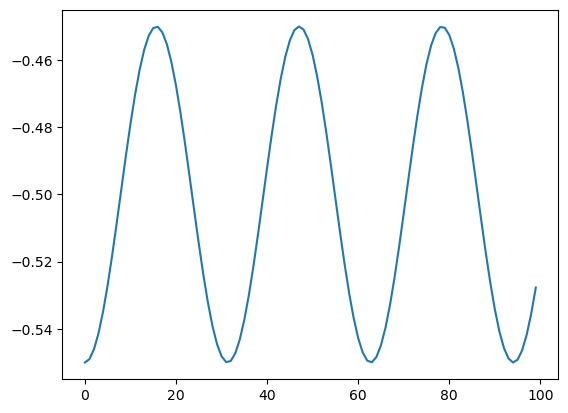

In [4]:
import matplotlib.pyplot as plt
plt.plot((pos_x1-pos_x2).detach().numpy())
